# Choice of a function for author payouts

## Initialize libraries and DB

In [2]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from tqdm import tqdm
%matplotlib inline

In [3]:
client = MongoClient("localhost:27017")
database = client["golos_comments"]
database_1 = client["steemdb_1"]
database_2 = client["golos_all_tsx"]
collection_account = database["account"]
collection_comment = database["comment"]
collection_feed_publish = database_2["feed_publish"]
collection_global_properties = database_1["global_properties"]

## Initialize constants

In [4]:
PERCENT = 10000
s = 2000000000000.0
precision = 3

## Load topics from MongoDB

Find all comments with nonzero votes

In [785]:
comment_df = pd.DataFrame(list(collection_comment.find({'net_votes' :{'$gt':0}},                                              
                                                       {'_id': 1, 
                                                        'author': 1, 
                                                        'last_payout': 1, 
                                                        'reward_weight' : 1,
                                                        'net_rshares' : 1,
                                                        'net_votes' : 1,
                                                        'total_payout_value' : 1,
                                                        'curator_payout_value': 1,
                                                        'pending_payout_value': 1,
                                                        'max_accepted_payout':1,
                                                        'root_comment' : 1,
                                                        'depth' : 1,
                                                        'active_votes':1,
                                                        'created':1,
                                                       'test':1})))

#### Remove comments with an error

In [786]:
comment_df = comment_df[comment_df["created"] > datetime(2000,1,1)]

#### Count 
    - last payout date, 
    - difference between creation and payout time, 
    - payout value

In [788]:
comment_df['last_payout'] = comment_df['last_payout'].map(lambda x: x if x==x else datetime(2000,1,1))
comment_df.loc[:,'payout_value'] = comment_df['total_payout_value']+ \
                                   comment_df['curator_payout_value']+ \
                                   comment_df['pending_payout_value']

## Load global properties from MongoDB

#### Load csv with global properties

In [789]:
global_properties_df = pd.read_csv('/home/earth/datascience/golos_sync/global_dynamic_properties.csv', sep=';')

#### Convert values to their original types:
    - total_reward_fund_steem - to float
    - total_reward_shares2 - to float
    - time - to datetime
    - time_rounded_min - to datetime, rounded to 1 min

In [790]:
global_properties_df.loc[:,'total_reward_fund_steem'] = global_properties_df['total_reward_fund_steem'].map(lambda x: float(x[:-6]))
global_properties_df.loc[:,'total_reward_shares2'] = global_properties_df['total_reward_shares2'].map(lambda x: float(x))
global_properties_df.loc[:,'time'] = pd.to_datetime(global_properties_df['time'])

## Calculate total_reward_rshares2 to check there is no errors in formulas

#### Find all comments created in a month timewindow ending on the 1st of February

In [791]:
start_date=datetime(2018,2,1,0,0)

global_properties_df = global_properties_df[global_properties_df['time']>=start_date]

comment_with_votes_df = comment_df[(comment_df['created']>start_date-timedelta(35))&\
                                   (comment_df['created']<start_date+timedelta(2))]
print('Count of comments with votes: {}'.format(len(comment_with_votes_df)))

Count of comments with votes: 93165


#### Initialize functions to count rshares:
- Quadratic
- Linear
- Quadratic, with another constant
- Polynomial, degree = 1.5
- Loglinear

In [792]:
def rs2(rshares):
    if rshares<=0:
        return 0
    return (rshares+s)**2-s**2

def rs_linear(rshares):
    if rshares<=0:
        return 0
    return rshares

def rs2_2(rshares):
    if rshares<=0:
        return 0
    multi_s = 10
    return (rshares+s*multi_s)**2-(s*multi_s)**2

def rs2_3(rshares):
    if rshares<=0:
        return 0
    multi_s = 50
    return (rshares+s*multi_s)**2-(s*multi_s)**2

def rs2_4(rshares):
    if rshares<=0:
        return 0
    multi_s = 100
    return (rshares+s*multi_s)**2-(s*multi_s)**2

def rs15(rshares):
    if rshares<=0:
        return 0
    return (rshares+s)**1.5-s**1.5

def rs15_2(rshares):
    if rshares<=0:
        return 0
    multi_s = 10
    return (rshares+s*multi_s)**1.5-(s*multi_s)**1.5

def rs_compose(rshares):
    if rshares<=0:
        return 0
    return rshares if rshares<s else s+math.log1p(rshares)*rshares - s*math.log1p(s)

#### Define function to count actual rshares for a comment x with a function f using events from a start date:
    - If last payout date is greater than a month from created date but before start date, return 0 (condition1)
    - For each active vote:
        - If vote has been made before start_date and before 33 days since creation date: (condition2, all statements)
            - If vote has been made after last payout date and last payout date is before start date, or;
            - If last payout date is after start_date and before a month from creation date, or;
            - If last payout date is after start_date and after a month from creation date, and vote has been made after a day from a creation date, or;
            - If there was no payout
    - Apply f to rshares and return

#### Define function to count actual rshares for active votes from a start date:
    - If condition1, or comment was created after start date, return 0
    - For active votes:
        - If condition2, increase rshares
    - Return rshares

In [793]:
def rshares_for_active_votes(x, start_date=datetime(2017,12,12,23,55)):
    rshares = 0
    if ((x['last_payout'].to_pydatetime()>x['created'].to_pydatetime()+timedelta(30)) & \
        (x['last_payout'].to_pydatetime()<start_date)) | \
       (x['created']>start_date):
        return 0
    
    for items in x['active_votes']:
        if (items['time']<start_date) & \
           (items['time']<x['created'].to_pydatetime()+timedelta(33)):
            if ((items['time']>x['last_payout'].to_pydatetime()) & \
                (x['last_payout'].to_pydatetime()<start_date)):
                rshares+=items['rshares']
            elif (x['last_payout'].to_pydatetime()>=start_date) & \
                 (x['last_payout'].to_pydatetime()<=x['created'].to_pydatetime()+timedelta(30)):
                rshares+=items['rshares']
            elif (x['last_payout'].to_pydatetime()>=start_date) & \
                 (x['last_payout'].to_pydatetime()>=x['created'].to_pydatetime()+timedelta(30)) & \
                 (items['time']>x['created'].to_pydatetime()+timedelta(1)):
                rshares+=items['rshares']
            elif x['last_payout'].to_pydatetime()==datetime(1970,1,1):
                rshares+=items['rshares']

    rshares = max(rshares, 0)
    return rshares

#### Set start date as the 1st of February and count rshares with a function above for each extracted comment 

In [ ]:
start_date=datetime(2018,2,1,0,0)

#### Count alternative actual rshares for each comment

- Count actual rshares for different start date (february the 1st + 2 days by 20 minutes interval)
- Save results to a list_total_reward
- Save actual total_reward_shares2 from global properties (as a mean of all total reward shares in 10 minutes window centered in start_date)

In [ ]:
list_total_reward = [] 
for i in tqdm(range(144)):
    start_date = datetime(2018,2,1,0,0) + timedelta(minutes = i*20)
    list_total_reward_item=[start_date]
    comment_with_votes_df.loc[:, 'actual_rshares'] = comment_with_votes_df.apply(lambda x: rshares_for_active_votes(x, start_date), axis=1)

    for item in [['actual_rshares2', rs2], 
                 ['actual_rshares_linear', rs_linear], 
                 ['actual_rshares2_2', rs2_2], 
                 ['actual_rshares2_3', rs2_3], 
                 ['actual_rshares2_4', rs2_4], 
                 ['actual_rshares15', rs15],
                 ['actual_rshares15_2', rs15_2],
                 ['actual_rshares_compose', rs_compose]]:
        list_total_reward_item.append(sum(comment_with_votes_df['actual_rshares'].map(item[1])))
        
   
    list_total_reward_item.append(np.mean(global_properties_df[(global_properties_df['time']>start_date-timedelta(minutes=5)) &
                             (global_properties_df['time']<start_date+timedelta(minutes=5))]['total_reward_shares2']))

    list_total_reward.append(list_total_reward_item)

  0%|          | 0/144 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
  1%|          | 1/144 [05:14<12:29:08, 314.33s/it]

In [797]:
total_reward_df = pd.DataFrame(data=list_total_reward, columns=['start_date',
                                                                'total_reward_rshares2', 
                                                                'total_reward_rshares_linear', 
                                                                'total_reward_rshares2_2',
                                                                'total_reward_rshares2_3',
                                                                'total_reward_rshares2_4',
                                                                'total_reward_rshares15',
                                                                'total_reward_rshares15_2',
                                                                'total_reward_rshares_compose',
                                                                'total_reward_rshares2_real'])

In [798]:
total_reward_df.to_csv('total_reward_18_02_01_v2.csv')

## Calculate rshares & rshares in first day

#### Use comments with last payout between the 1st and 3rd of February

In [834]:
start_date = datetime(2018,2,1,0,0)
comment_with_votes_df = comment_with_votes_df[(comment_with_votes_df['created']>start_date-timedelta(1))&\
                                              (comment_with_votes_df['created']<start_date+timedelta(1)) &\
                                              (comment_with_votes_df['last_payout'] < start_date + timedelta(days=1,hours=9))&\
                                              (comment_with_votes_df['last_payout'] > start_date)]

#### Define a function to calculate rshares in a first day

Apply it to selected comments

In [835]:
def rshares_first_day_calculate(x):
    rshares = 0
    for items in x['active_votes']:
        if items['time'] < x['last_payout']:
            rshares+=items['rshares']
    return rshares   

comment_with_votes_df.loc[:,'rshares_first_day'] = comment_with_votes_df.apply(rshares_first_day_calculate, axis=1)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Count rshares for comments using different functions

In [836]:
for item in [['rshares2', rs2], 
             ['rshares_linear', rs_linear], 
             ['rshares2_2', rs2_2], 
             ['rshares2_3', rs2_3], 
             ['rshares2_4', rs2_4], 
             ['rshares15', rs15],
             ['rshares15_2', rs15_2],
             ['rshares_compose', rs_compose]]:
    comment_with_votes_df.loc[:,item[0]] = comment_with_votes_df['rshares_first_day'].map(item[1])

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Count total payout for each function

In [837]:
comment_with_votes_df.loc[:,'last_payout_rounded_min'] = comment_with_votes_df['last_payout'].map(lambda x: x - timedelta(seconds=x.second,
                                                                                                    microseconds=x.microsecond))

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [838]:
comment_with_votes_df['permlink'] = comment_with_votes_df['_id'].map(lambda x: x.split('/', 1)[1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [866]:
comment_gl_prop_df = pd.merge(comment_with_votes_df[['author', 
                                                     'created', 
                                                     'permlink',
                                                     'depth', 
                                                     'last_payout', 
                                                     'net_votes', 
                                                     'reward_weight', 
                                                     'payout_value', 
                                                     'rshares_first_day', 
                                                     'rshares2', 
                                                     'rshares_linear', 
                                                     'rshares2_2', 
                                                     'rshares2_3', 
                                                     'rshares2_4', 
                                                     'rshares15', 
                                                     'rshares15_2', 
                                                     'rshares_compose', 
                                                     'last_payout_rounded_min']], 
                              global_properties_df[["total_reward_shares2", 
                                                    "total_reward_fund_steem", 
                                                    "time"]],
                              how='left',
                              left_on='last_payout', 
                              right_on='time', 
                              suffixes=('_comment', '_prop'))

In [867]:
comment_gl_prop_df["time_20_rounded_min"] = comment_gl_prop_df["last_payout_rounded_min"].dt.round("20min")

In [868]:
total_reward_df["start_date_20"] = pd.to_datetime(total_reward_df["start_date"])

In [869]:
comment_gl_prop_df = pd.merge(comment_gl_prop_df, 
                              total_reward_df, 
                              how='left',
                              left_on="time_20_rounded_min", 
                              right_on="start_date_20")

In [870]:
for f in ['rshares2', 
          'rshares_linear', 
          'rshares15', 
          'rshares15_2',
          'rshares2_2', 
          'rshares2_3', 
          'rshares2_4', 
          "rshares_compose"]:
    comment_gl_prop_df['payout_' + f] = comment_gl_prop_df[f]*comment_gl_prop_df['total_reward_fund_steem']/comment_gl_prop_df['total_reward_' + f]

In [871]:
for f in ['rshares2', 
          'rshares_linear', 
          'rshares15', 
          'rshares15_2',
          'rshares2_2', 
          'rshares2_3', 
          'rshares2_4', 
          "rshares_compose"]:
    comment_gl_prop_df['payout_' + f] = comment_gl_prop_df['payout_' + f]*sum(comment_gl_prop_df['payout_rshares2'])/sum(comment_gl_prop_df['payout_' + f])

#### Group comments by author categories

In [872]:
comment_gl_prop_authors_df = comment_gl_prop_df.merge(authors, 
                                                      how='left',
                                                      right_on=["author", "permlink"],
                                                      left_on=["author", "permlink"])
comment_gl_prop_authors_df.cat=comment_gl_prop_authors_df.cat.map(lambda x: x if x==x else 'Независимые авторы')

In [873]:
stacked_df = comment_gl_prop_authors_df.groupby("cat")[["payout_rshares2", 
                                                        "payout_rshares2_2",
                                                        "payout_rshares15",
                                                        "payout_rshares_linear", 
                                                        "payout_rshares_compose"]].sum()

#### Draw stacked barchart for payouts calculated with specified functions

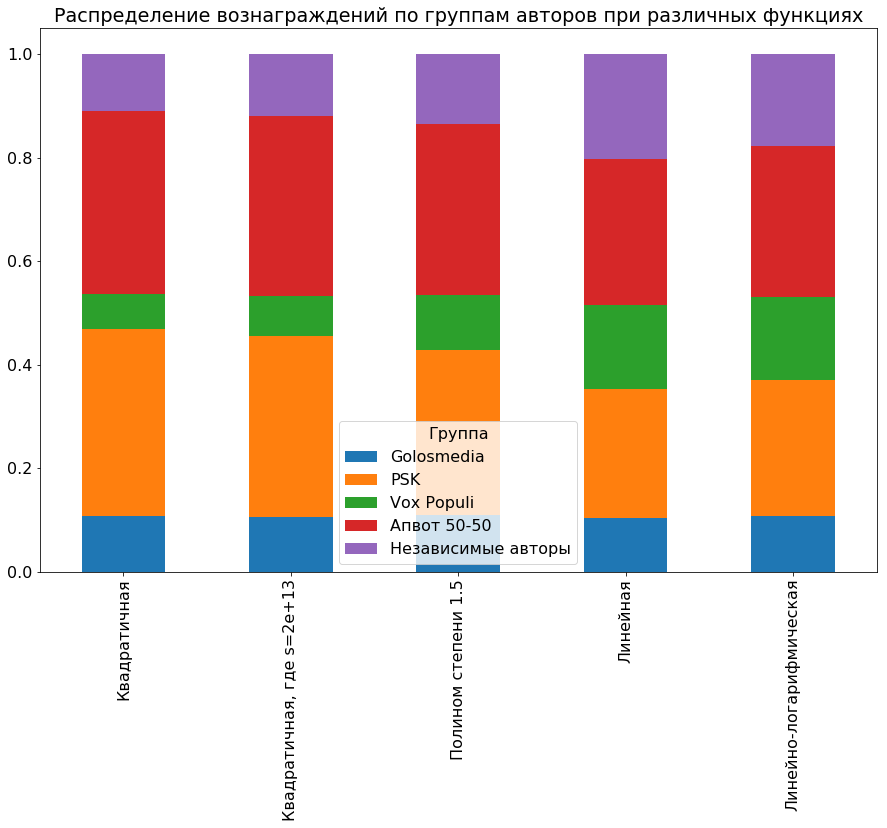

In [875]:
mpl.rcParams['figure.figsize'] = (18.0, 9.0)
plt.rcParams.update({'font.size': 16})
plot = (stacked_df / stacked_df.sum()).T.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title("Распределение вознаграждений по группам авторов при различных функциях")
plt.legend(title="Группа")
plot.set_xticklabels(["Квадратичная",  
                      "Квадратичная, где s=2e+13",
                      "Полином степени 1.5",                       
                      "Линейная", 
                      "Линейно-логарифмическая"])
plt.show()

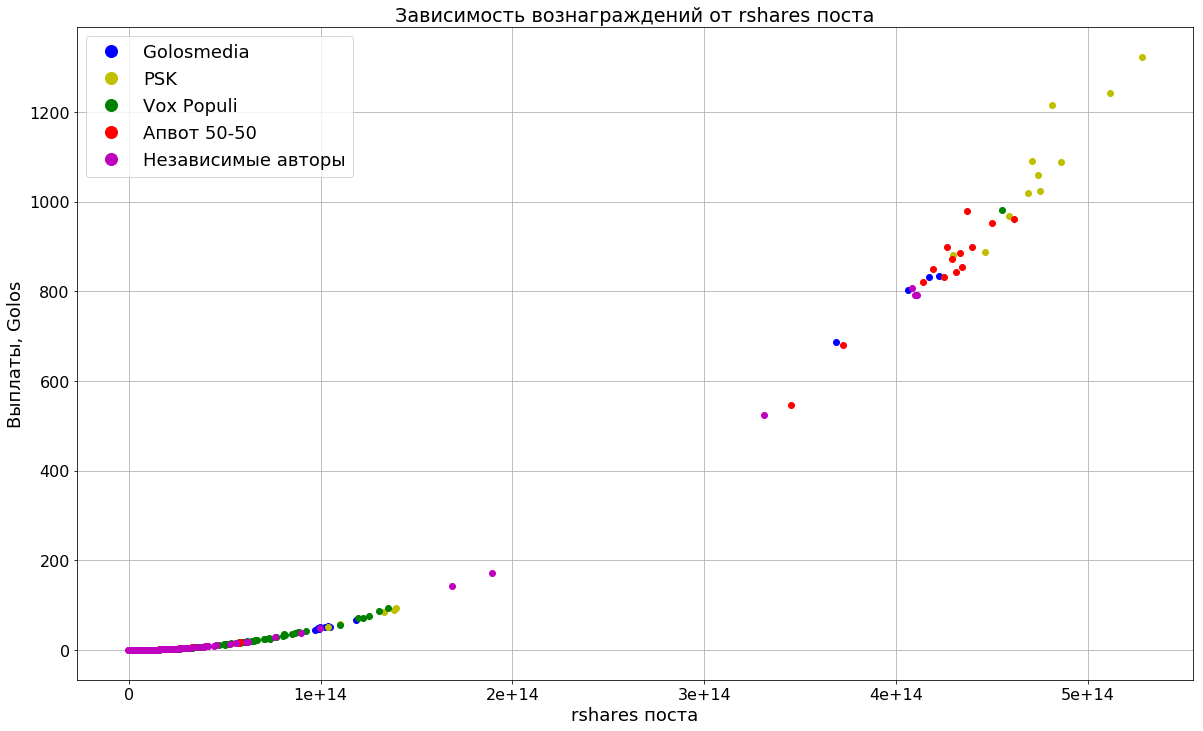

In [932]:
mpl.rcParams['figure.figsize'] = (20.0, 12.0)
for category, color in [['Golosmedia', 'bo'], 
                        ['PSK', 'yo'], 
                        ['Vox Populi', 'go'], 
                        ['Апвот 50-50', 'ro'], 
                        ['Независимые авторы', 'mo']]:
    plt.plot(comment_gl_prop_authors_df[comment_gl_prop_authors_df.cat==category].rshares_first_day, 
             comment_gl_prop_authors_df[comment_gl_prop_authors_df.cat==category].payout_rshares2,
             color, ms=6, label=category)

plt.title("Зависимость вознаграждений от rshares поста")
plt.ylabel('Выплаты, Golos', fontsize=18)
plt.xlabel('rshares поста', fontsize=18)
plt.legend(fontsize=18, loc=2, markerscale=2)
plt.xticks([0, 1e+14,2e+14,3e+14, 4e+14, 5e+14], ['0', '1e+14', '2e+14', '3e+14', '4e+14', '5e+14'])
plt.grid(True)
plt.show()

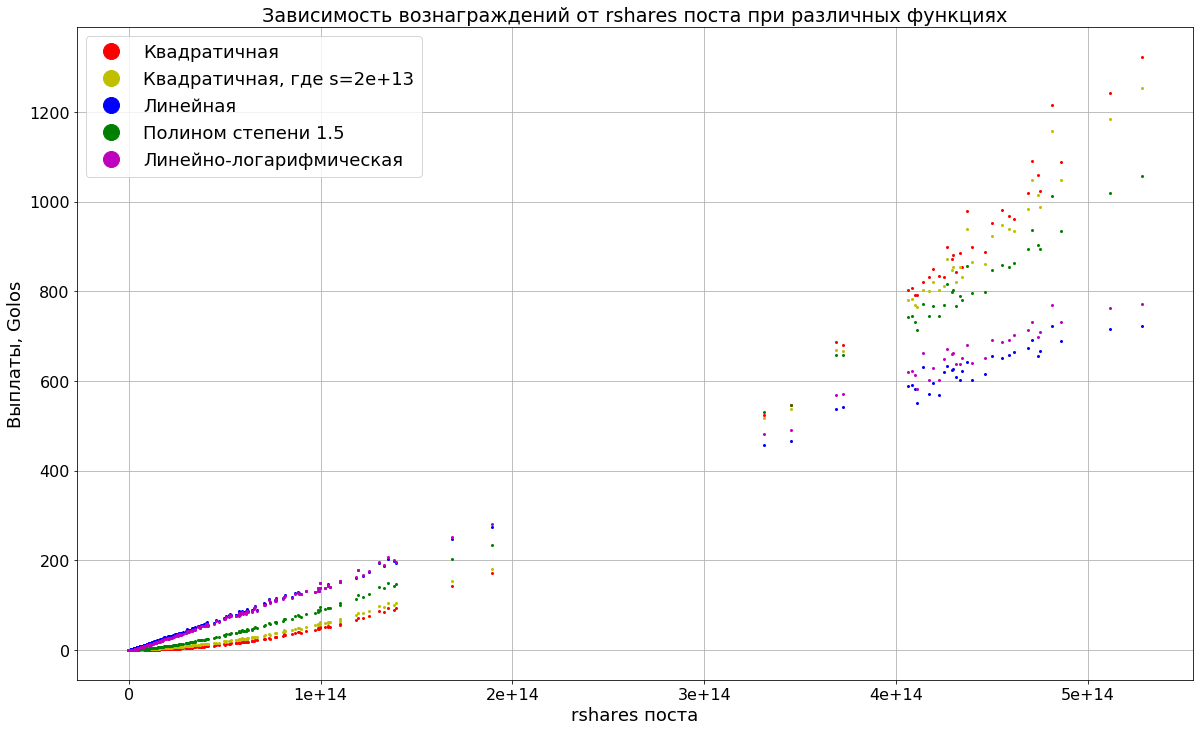

In [933]:
mpl.rcParams['figure.figsize'] = (20.0, 12.0)
plt.plot(comment_gl_prop_authors_df.rshares_first_day, comment_gl_prop_authors_df.payout_rshares2,'ro', ms=2, label='Квадратичная')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, comment_gl_prop_authors_df.payout_rshares2_2, 'yo', ms=2, label='Квадратичная, где s=2e+13')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, comment_gl_prop_authors_df.payout_rshares_linear, 'bo', ms=2, label='Линейная')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, comment_gl_prop_authors_df.payout_rshares15, 'go', ms=2, label='Полином степени 1.5')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, comment_gl_prop_authors_df.payout_rshares_compose, 'mo', ms=2, label='Линейно-логарифмическая')
plt.title("Зависимость вознаграждений от rshares поста при различных функциях")
plt.ylabel('Выплаты, Golos', fontsize=18)
plt.xlabel('rshares поста', fontsize=18)
plt.legend(fontsize=18, loc=2, markerscale=8)
plt.xticks([0, 1e+14,2e+14,3e+14, 4e+14, 5e+14], ['0', '1e+14', '2e+14', '3e+14', '4e+14', '5e+14'])
plt.grid(True)
plt.show()

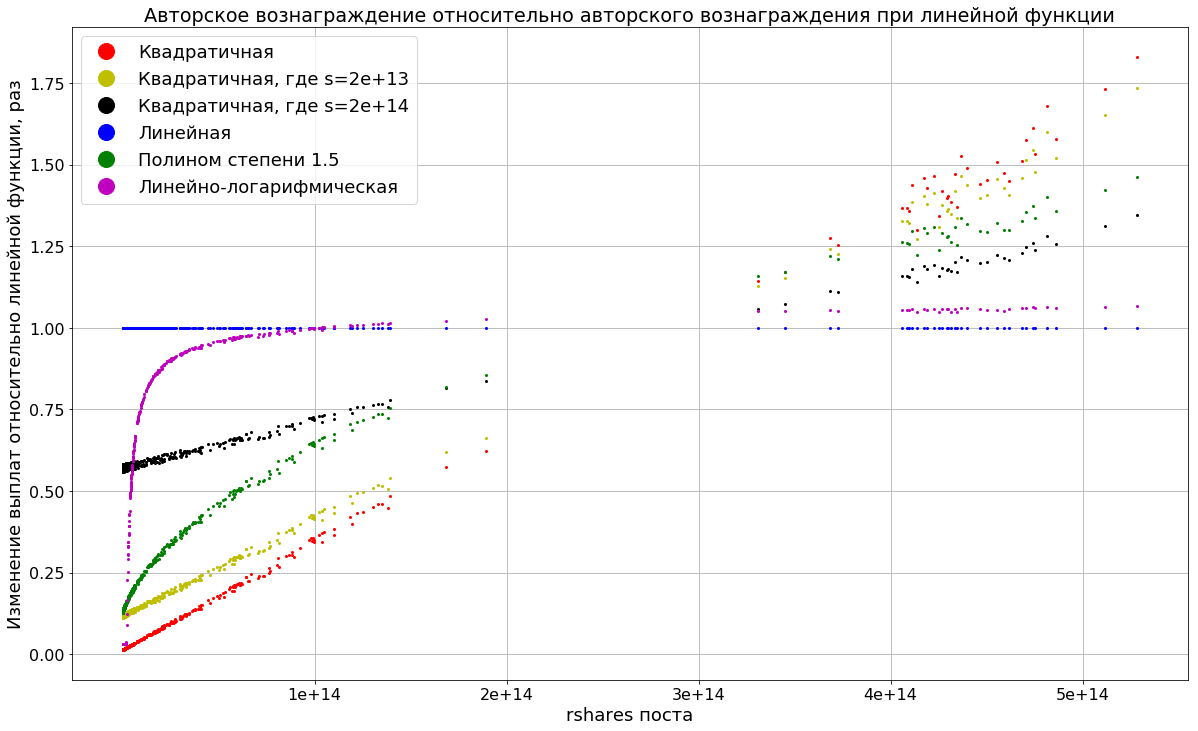

In [924]:
mpl.rcParams['figure.figsize'] = (20.0, 12.0)
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2/comment_gl_prop_authors_df.payout_rshares_linear,
         'ro', ms=2, label='Квадратичная')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2_2/comment_gl_prop_authors_df.payout_rshares_linear, 
         'yo', ms=2, label='Квадратичная, где s=2e+13')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2_4/comment_gl_prop_authors_df.payout_rshares_linear, 
         'ko', ms=2, label='Квадратичная, где s=2e+14')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares_linear/comment_gl_prop_authors_df.payout_rshares_linear, 
         'bo', ms=2, label='Линейная')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares15/comment_gl_prop_authors_df.payout_rshares_linear, 
         'go', ms=2, label='Полином степени 1.5')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares_compose/comment_gl_prop_authors_df.payout_rshares_linear, 
         'mo', ms=2, label='Линейно-логарифмическая')
plt.title("Авторское вознаграждение относительно авторского вознаграждения при линейной функции")
plt.ylabel('Изменение выплат относительно линейной функции, раз', fontsize=18)
plt.xlabel('rshares поста', fontsize=18)
plt.legend(fontsize=18, loc=2, markerscale=8)
plt.grid(True)
plt.xticks([0, 1e+14,2e+14,3e+14, 4e+14, 5e+14], ['0', '1e+14', '2e+14', '3e+14', '4e+14', '5e+14'])

plt.show()

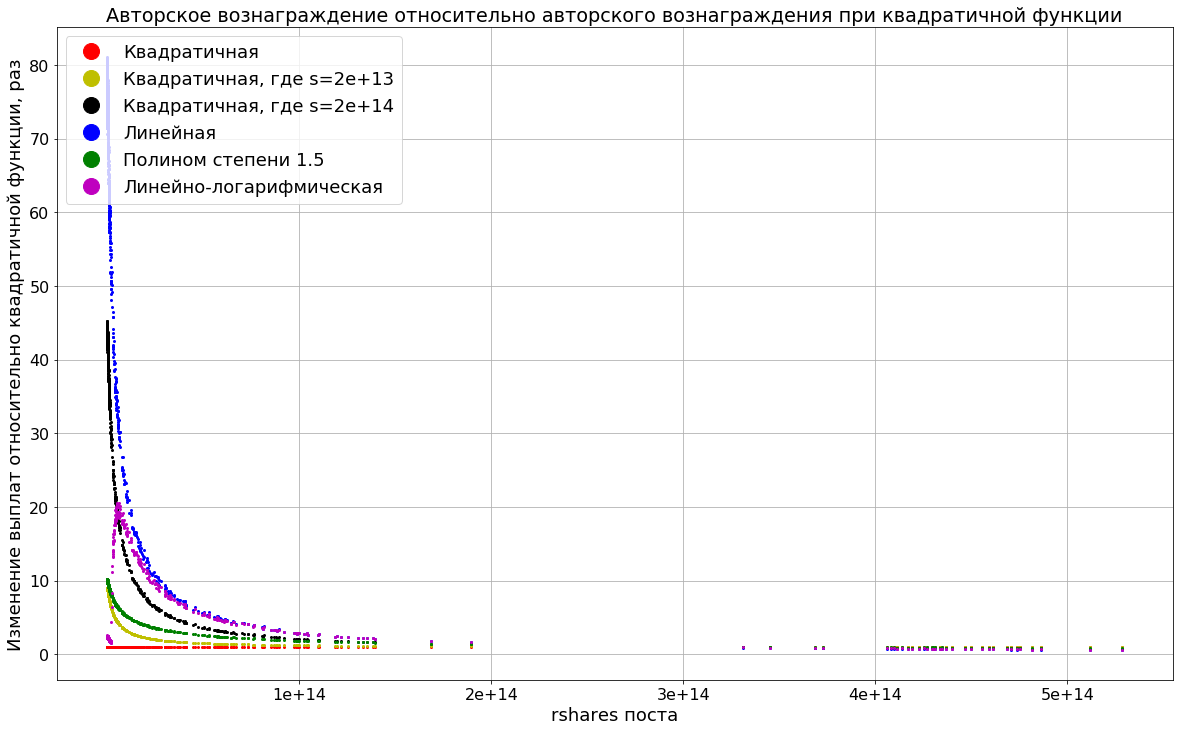

/home/earth/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


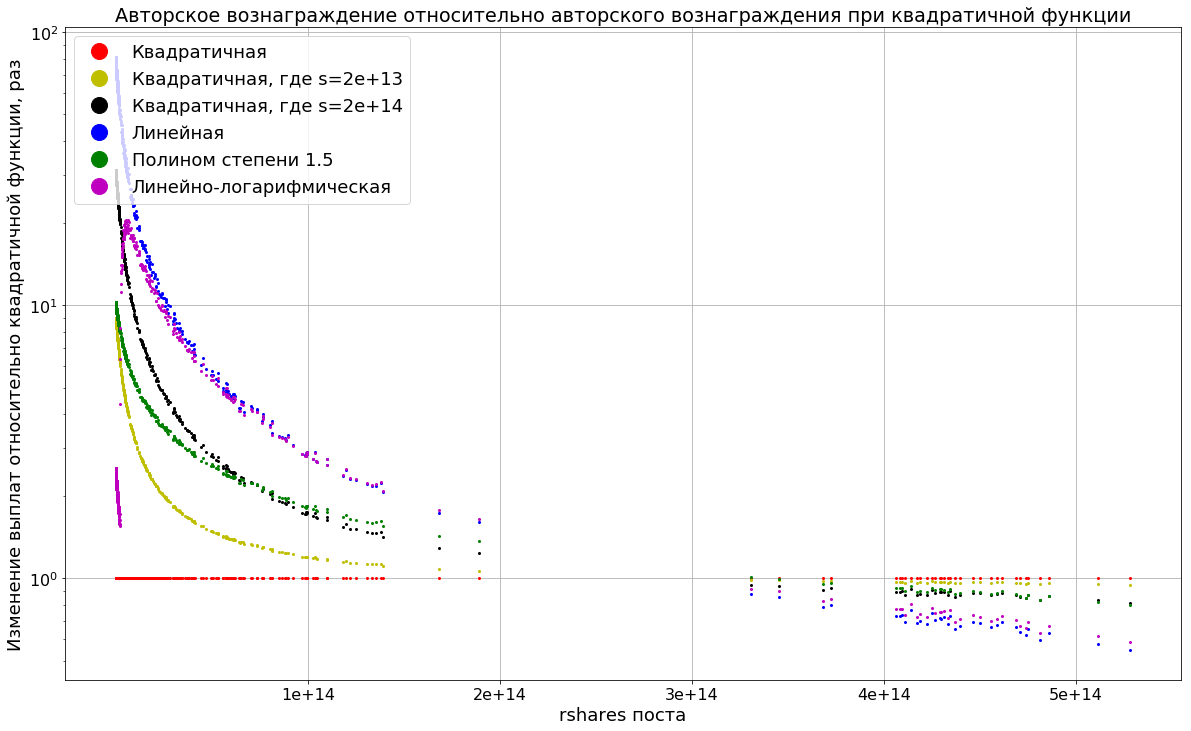

In [930]:
mpl.rcParams['figure.figsize'] = (20.0, 12.0)
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2/comment_gl_prop_authors_df.payout_rshares2,
         'ro', ms=2, label='Квадратичная')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2_2/comment_gl_prop_authors_df.payout_rshares2, 
         'yo', ms=2, label='Квадратичная, где s=2e+13')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2_4/comment_gl_prop_authors_df.payout_rshares2, 
         'ko', ms=2, label='Квадратичная, где s=2e+14')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares_linear/comment_gl_prop_authors_df.payout_rshares2, 
         'bo', ms=2, label='Линейная')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares15/comment_gl_prop_authors_df.payout_rshares2, 
         'go', ms=2, label='Полином степени 1.5')
plt.plot(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares_compose/comment_gl_prop_authors_df.payout_rshares2, 
         'mo', ms=2, label='Линейно-логарифмическая')
plt.title("Авторское вознаграждение относительно авторского вознаграждения при квадратичной функции")
plt.ylabel('Изменение выплат относительно квадратичной функции, раз', fontsize=18)
plt.xlabel('rshares поста', fontsize=18)
plt.legend(fontsize=18, loc=2, markerscale=8)
plt.grid(True)
plt.xticks([0, 1e+14,2e+14,3e+14, 4e+14, 5e+14], ['0', '1e+14', '2e+14', '3e+14', '4e+14', '5e+14'])
plt.show()

mpl.rcParams['figure.figsize'] = (20.0, 12.0)
plt.semilogy(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2/comment_gl_prop_authors_df.payout_rshares2,
         'ro', ms=2, label='Квадратичная')
plt.semilogy(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2_2/comment_gl_prop_authors_df.payout_rshares2, 
         'yo', ms=2, label='Квадратичная, где s=2e+13')
plt.semilogy(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares2_3/comment_gl_prop_authors_df.payout_rshares2, 
         'ko', ms=2, label='Квадратичная, где s=2e+14')
plt.semilogy(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares_linear/comment_gl_prop_authors_df.payout_rshares2, 
         'bo', ms=2, label='Линейная')
plt.semilogy(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares15/comment_gl_prop_authors_df.payout_rshares2, 
         'go', ms=2, label='Полином степени 1.5')
plt.semilogy(comment_gl_prop_authors_df.rshares_first_day, 
         comment_gl_prop_authors_df.payout_rshares_compose/comment_gl_prop_authors_df.payout_rshares2, 
         'mo', ms=2, label='Линейно-логарифмическая')
plt.title("Авторское вознаграждение относительно авторского вознаграждения при квадратичной функции")
plt.ylabel('Изменение выплат относительно квадратичной функции, раз', fontsize=18)
plt.xlabel('rshares поста', fontsize=18)
plt.legend(fontsize=18, loc=2, markerscale=8)
plt.grid(True)
plt.xticks([1e+14,2e+14,3e+14, 4e+14, 5e+14], ['1e+14', '2e+14', '3e+14', '4e+14', '5e+14'])
plt.show()